In [1]:
from pathlib import Path
home = str(Path.home())
path = home + '/datasets/MRNet/'
train_path = path + 'train/'
valid_path = path + 'valid/'

In [2]:
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi=False

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm_notebook
import os
from ipywidgets.embed import embed_minimal_html

In [11]:
case = '0000'

mri_coronal = np.load(path + 'train/coronal/0000.npy')
mri_axial = np.load(path + 'train/axial/0000.npy')
mri_sagittal = np.load(path + 'train/sagittal/0000.npy')

print(f'MRI scan on coronal plane: {mri_coronal.shape}')
print(f'MRI scan on axial plane: {mri_axial.shape}')
print(f'MRI scan on sagittal plane: {mri_sagittal.shape}')

MRI scan on coronal plane: (36, 256, 256)
MRI scan on axial plane: (44, 256, 256)
MRI scan on sagittal plane: (36, 256, 256)


In [102]:
mri_coronal.shape

(36, 256, 256)

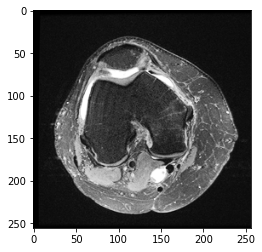

In [61]:
image_bw = mri_axial[22, :, :]
image_rgb = np.stack((image_bw, image_bw, image_bw), axis = 2) / 255.0
plt.imshow(image_rgb)

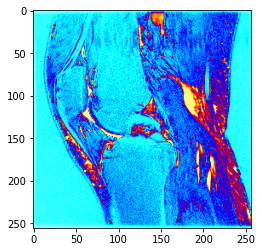

In [75]:
heatmap = np.stack((np.ones((256, 256)) * 255, np.zeros((256, 256)), np.zeros((256, 256))), axis = 2) / 255.0
heatmap = cv2.applyColorMap(mri_sagittal[18, :, :], cv2.COLORMAP_JET) 
heatmap = cv2.bitwise_not(heatmap) / 255.0
plt.imshow(heatmap)

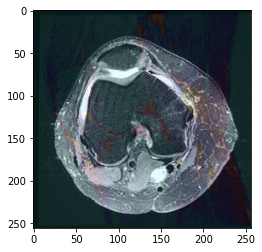

In [82]:
combined = cv2.addWeighted(heatmap, 0.1, image_rgb, 0.90, 0)
plt.imshow(combined)

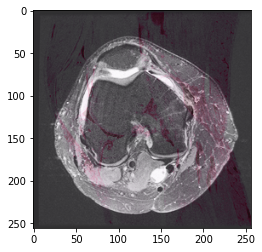

In [97]:
im1 = plt.imshow(mri_axial[22, :, :], cmap=plt.cm.gray)
im2 = plt.imshow(mri_sagittal[18, :, :], cmap=plt.cm.PuRd, alpha=.2)
plt.show()

In [10]:
mri_axial = np.load(path + 'valid/axial/1130.npy')
att_axial = np.load(path + 'valid/attention/axial/1130.npy')

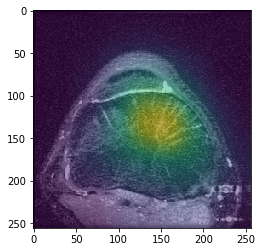

In [11]:
heatmap = np.mean(att_axial, axis=(1))[18, :, :]
heatmap = cv2.resize(heatmap, (256, 256), interpolation = cv2.INTER_CUBIC)
fig = plt.figure(frameon=False)
im1 = plt.imshow(mri_axial[18, :, :], cmap=plt.cm.gray, interpolation='nearest')
im2 = plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=.5, interpolation='bilinear')

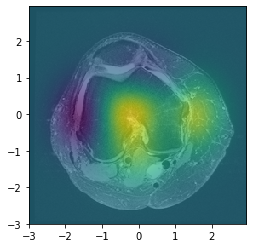

In [101]:
"""
Layer images above one another using alpha blending
"""
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np


def func3(x, y):
    return (1 - x/2 + x**5 + y**3)*np.exp(-(x**2 + y**2))

# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

x = np.arange(-3.0, 3.0, dx)
y = np.arange(-3.0, 3.0, dy)
X, Y = np.meshgrid(x, y)

xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
extent = xmin, xmax, ymin, ymax
fig = plt.figure(frameon=False)

im1 = plt.imshow(mri_axial[22, :, :], cmap=plt.cm.gray, interpolation='nearest',
                 extent=extent)

Z2 = func3(X, Y)

im2 = plt.imshow(Z2, cmap=plt.cm.viridis, alpha=.7, interpolation='bilinear',
                 extent=extent)

plt.show()

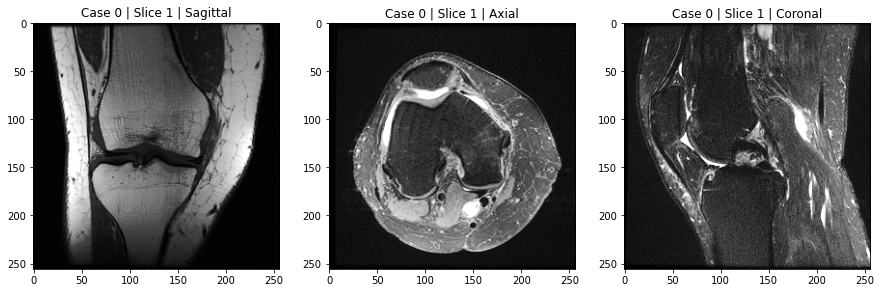

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(mri_coronal[18, :, :], 'gray');
ax1.set_title('Case 0 | Slice 1 | Sagittal');

ax2.imshow(mri_axial[22, :, :], 'gray');
ax2.set_title('Case 0 | Slice 1 | Axial');

ax3.imshow(mri_sagittal[18, :, :], 'gray');
ax3.set_title('Case 0 | Slice 1 | Coronal');

In [3]:
def load_one_stack(case, data_path=train_path, plane='coronal'):
    fpath = '{}/{}/{}.npy'.format(data_path, plane, case)
    return np.load(fpath)

def load_one_att_stack(case, data_path=train_path, plane='coronal'):
    fpath = '{}attention/{}/{}.npy'.format(data_path, plane, case)
    if os.path.exists(fpath):
        att = np.load(fpath)
        heatmap = np.mean(att, axis=(1))
        return heatmap
    else:
        None

def load_stacks(case, data_path=train_path):
    x = {}
    planes = ['coronal', 'sagittal', 'axial']
    for i, plane in enumerate(planes):
        x[plane] = load_one_stack(case, data_path, plane)
    return x

def load_att_stacks(case, data_path=train_path):
    x = {}
    planes = ['coronal', 'sagittal', 'axial']
    for i, plane in enumerate(planes):
        x[plane] = load_one_att_stack(case, data_path, plane)
    return x

def load_cases(train=False, n=None):
    assert (type(n) == int) and (n < 1250)
    if train:
        case_list = pd.read_csv(path + 'train-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    else:
        case_list = pd.read_csv(path + 'valid-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    cases = {}
    atts = {}
    
    if n is not None:
        case_list = case_list[:n]
        
    for case in tqdm_notebook(case_list, leave=False):
        x = load_stacks(case, valid_path)
        att = load_att_stacks(case, valid_path)
        cases[case] = x
        if att is None:
            atts[case] = np.zeros(x.shape)
        else:
            atts[case] = att
    return cases, atts

cases, atts = load_cases(n=120)

/home/jensnau/anaconda3/envs/make/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/120 [00:00<?, ?it/s]

In [11]:
class KneePlot():
    def __init__(self, cases, atts, figsize=(15, 5)):
        self.cases = cases
        self.atts = atts
        self.planes = {case: ['coronal', 'sagittal', 'axial'] for case in self.cases}
        self.attention = False

        self.slice_nums = {}
        for case in self.cases:
            self.slice_nums[case] = {}
            for plane in ['coronal', 'sagittal', 'axial']:
                self.slice_nums[case][plane] = self.cases[case][plane].shape[0]

        self.figsize = figsize

    def _plot_slices(self, case, im_slice_coronal, im_slice_sagittal, im_slice_axial):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=self.figsize)

        ax1.imshow(self.cases[case]['coronal'][im_slice_coronal, :, :], 'gray')
        if self.attention:
            ax1.imshow(cv2.resize(self.atts[case]['coronal'][im_slice_coronal, :, :], (256, 256), interpolation=cv2.INTER_CUBIC), cmap=plt.cm.viridis, alpha=.5)
        ax1.set_title(f'MRI slice {im_slice_coronal} on coronal plane')

        ax2.imshow(self.cases[case]['sagittal'][im_slice_sagittal, :, :], 'gray')
        if self.attention:
            ax2.imshow(cv2.resize(self.atts[case]['sagittal'][im_slice_sagittal, :, :], (256, 256), interpolation=cv2.INTER_CUBIC), cmap=plt.cm.viridis, alpha=.5)
        ax2.set_title(f'MRI slice {im_slice_sagittal} on sagittal plane')

        ax3.imshow(self.cases[case]['axial'][im_slice_axial, :, :], 'gray')
        if self.attention:
            ax3.imshow(cv2.resize(self.atts[case]['axial'][im_slice_axial, :, :], (256, 256), interpolation=cv2.INTER_CUBIC), cmap=plt.cm.viridis, alpha=.5)
        ax3.set_title(f'MRI slice {im_slice_axial} on axial plane')

        plt.show()
        
    def draw(self):
                                
        case_widget = Dropdown(options=list(self.cases.keys()), description='Case')
        
        case_init = list(self.cases.keys())[0]

        slice_init_coronal = self.slice_nums[case_init]['coronal'] - 1
        slices_widget_coronal = IntSlider(min=0,
                                          max=slice_init_coronal,
                                          value=slice_init_coronal // 2,
                                          description='Coronal')

        slice_init_sagittal = self.slice_nums[case_init]['sagittal'] - 1
        slices_widget_sagittal = IntSlider(min=0,
                                           max=slice_init_sagittal,
                                           value=slice_init_sagittal // 2,
                                           description='Sagittal')

        slice_init_axial = self.slice_nums[case_init]['axial'] - 1
        slices_widget_axial = IntSlider(min=0,
                                        max=slice_init_axial,
                                        value=slice_init_axial // 2,
                                        description='Axial')
        
        def update_slices_widget(*args):
            slices_widget_coronal.max = self.slice_nums[case_widget.value]['coronal'] - 1
            slices_widget_coronal.value = slices_widget_coronal.max // 2

            slices_widget_sagittal.max = self.slice_nums[case_widget.value]['sagittal'] - 1
            slices_widget_sagittal.value = slices_widget_sagittal.max // 2

            slices_widget_axial.max = self.slice_nums[case_widget.value]['axial'] - 1
            slices_widget_axial.value = slices_widget_axial.max // 2

        case_widget.observe(update_slices_widget, 'value')
        interact(self._plot_slices,
                 case=case_widget,
                 im_slice_coronal=slices_widget_coronal,
                 im_slice_sagittal=slices_widget_sagittal,
                 im_slice_axial=slices_widget_axial
                 )

    def resize(self, figsize):
        self.figsize = figsize

In [12]:
plot = KneePlot(cases, atts)
plot.draw()

interactive(children=(Dropdown(description='Case', options=('1130', '1131', '1132', '1133', '1134', '1135', '1…